# Dependencies


In [1]:
#!pip install yfinance
#!pip install hmmlearn

In [2]:
import yfinance as yf
from datetime import date
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 12]

# Data Gathering


In [3]:
stonks = ['SPY']
df = yf.download(stonks)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.941395,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.118782,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.172007,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.438107,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.544554,531500
...,...,...,...,...,...,...
2023-11-28,454.079987,456.269989,453.500000,454.929993,454.929993,62115000
2023-11-29,457.149994,458.320007,454.200012,454.609985,454.609985,63146000
2023-11-30,455.480011,456.760010,453.339996,456.399994,456.399994,79752700


In [4]:
df['Log'] = np.log(df['Close'])
df['Returns'] = df['Log'].pct_change()
df['Range'] = (df['High'] / df['Low']) - 1
df.dropna(inplace=True)
data = df[['Returns','Range']]
print(data.tail())

             Returns     Range
Date                          
2023-11-28  0.000162  0.006108
2023-11-29 -0.000115  0.009071
2023-11-30  0.000642  0.007544
2023-12-01  0.000963  0.009865
2023-12-04 -0.000927  0.005480


In [5]:
print(data.size)

15534


In [6]:
split_ratio = 0.75  
split_index = int(len(data) * split_ratio)

# Split the data into training and testing sets
train_data = data[:split_index]
test_data = data[split_index:]

print(train_data.size)
print(train_data)
print(test_data.size)
print(test_data)

11650
             Returns     Range
Date                          
1993-02-01  0.001874  0.006397
1993-02-02  0.000558  0.005666
1993-02-03  0.002773  0.010563
1993-02-04  0.001098  0.014055
1993-02-05 -0.000182  0.007687
...              ...       ...
2016-03-11  0.003023  0.016490
2016-03-14 -0.000242  0.006294
2016-03-15 -0.000307  0.007361
2016-03-16  0.001087  0.011263
2016-03-17  0.001190  0.012132

[5825 rows x 2 columns]
3884
             Returns     Range
Date                          
2016-03-18 -0.000230  0.004809
2016-03-21  0.000267  0.005594
2016-03-22 -0.000101  0.008154
2016-03-23 -0.001244  0.006502
2016-03-24 -0.000083  0.007039
...              ...       ...
2023-11-28  0.000162  0.006108
2023-11-29 -0.000115  0.009071
2023-11-30  0.000642  0.007544
2023-12-01  0.000963  0.009865
2023-12-04 -0.000927  0.005480

[1942 rows x 2 columns]


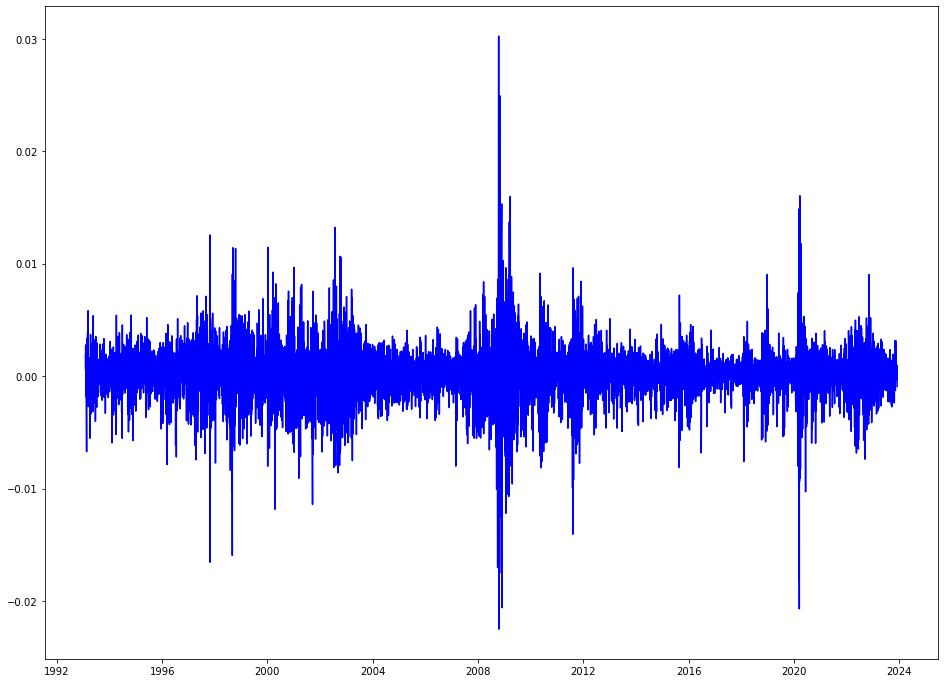

In [7]:
plt.plot(data['Returns'],color='blue')
#plt.plot(data['Range'],color='red')

# Model Fitting

In [8]:
model = hmm.GaussianHMM(n_components=3, covariance_type='full', n_iter = 1000, random_state = 1000)
model.fit(train_data)

GaussianHMM(covariance_type='full', n_components=3, n_iter=1000,
            random_state=1000)

In [9]:
model.score(train_data)

49264.60599099741

In [10]:
states = model.predict(test_data)

<AxesSubplot:>

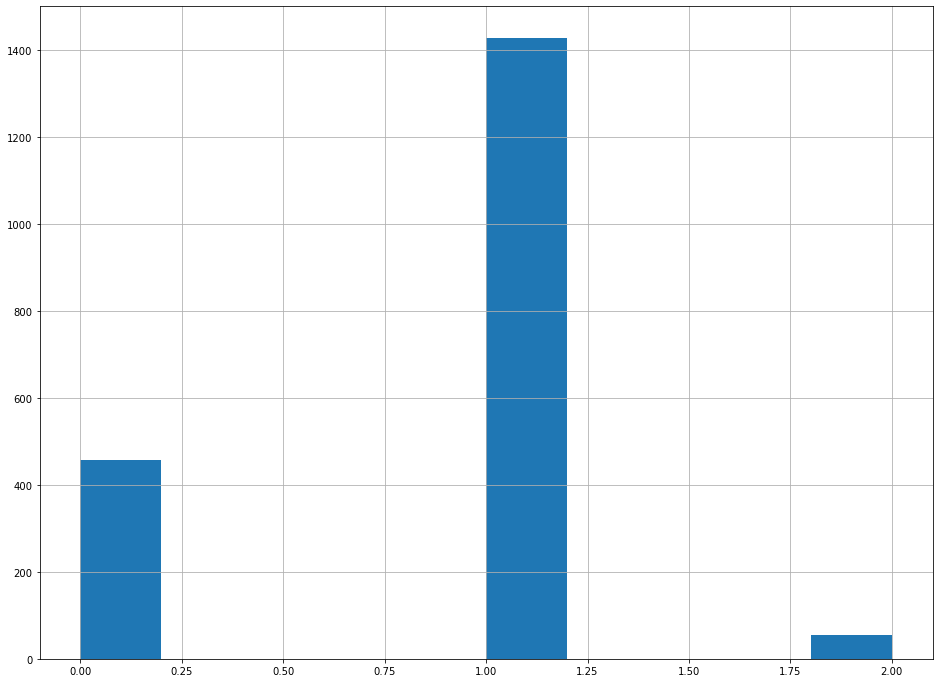

In [11]:
pd.Series(states).hist()

# Visuals

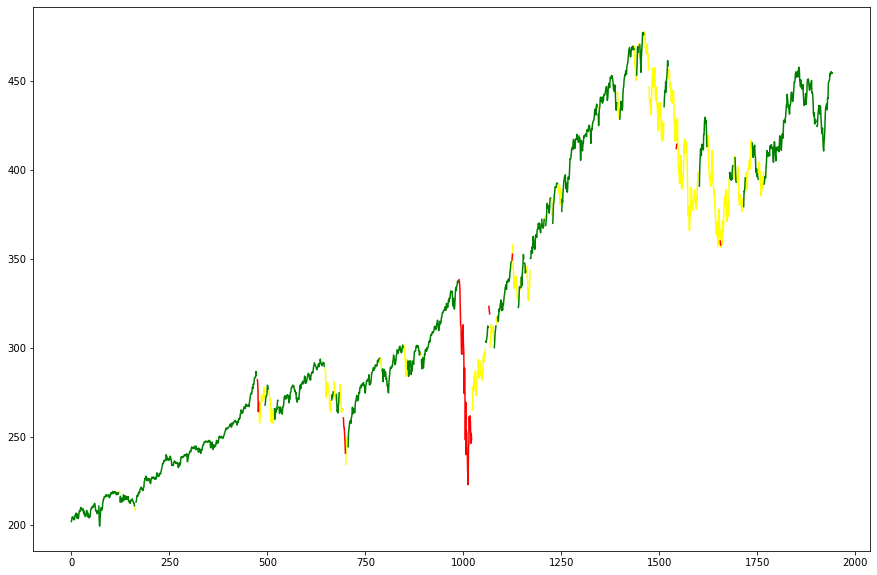

In [12]:
state1,state2,state3 = [],[],[]
i = 0
for state in states:
  if state == 0:
    state1.append(df['Close'][5822+i])
    state2.append(float('nan'))
    state3.append(float('nan'))
  if state == 1:
    state2.append(df['Close'][5822+i])
    state1.append(float('nan'))
    state3.append(float('nan'))
  if state == 2:
    state3.append(df['Close'][5822+i])
    state2.append(float('nan'))
    state1.append(float('nan'))
  i += 1
plt.figure(figsize=(15,10))
plt.plot(state1,color='yellow')
plt.plot(state2,color='green')
plt.plot(state3,color='red')

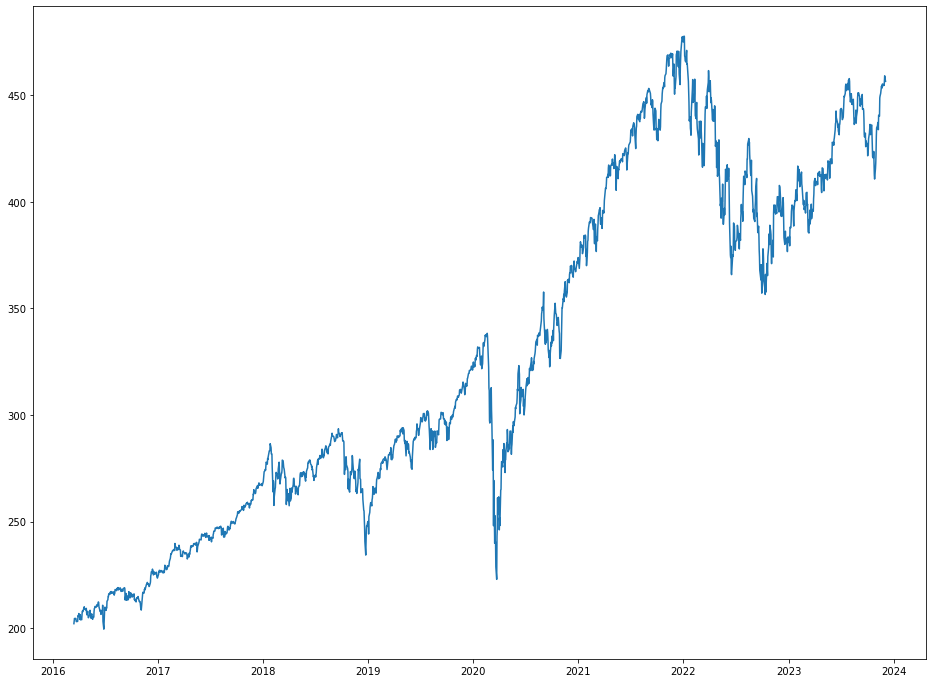

In [13]:
plt.plot(df['Close'].iloc[5822:])

In [14]:
print("Unique states:")
print(states)

Unique states:
[1 1 1 ... 1 1 1]


In [15]:
print("\nStart probabilities:")
print(model.startprob_)


Start probabilities:
[7.92351052e-147 1.00000000e+000 0.00000000e+000]


In [16]:
print("\nTransition matrix:")
print(model.transmat_)


Transition matrix:
[[8.82828116e-01 9.20951838e-02 2.50767000e-02]
 [4.86827043e-02 9.50698577e-01 6.18718508e-04]
 [2.00903851e-01 5.29249433e-25 7.99096149e-01]]


In [17]:
print("\nGaussian distribution means:")
print(model.means_)


Gaussian distribution means:
[[-0.00021759  0.01866268]
 [ 0.00028702  0.00886931]
 [-0.00101984  0.0457739 ]]


In [18]:
print("\nGaussian distribution covariances:")
print(model.covars_)


Gaussian distribution covariances:
[[[1.35700835e-05 4.07452577e-06]
  [4.07452577e-06 4.55140244e-05]]

 [[4.69447172e-06 3.24503667e-06]
  [3.24503667e-06 1.63010724e-05]]

 [[9.58849905e-05 4.38326808e-05]
  [4.38326808e-05 4.75045804e-04]]]


In [19]:
#plt.scatter(states,data['Returns'])

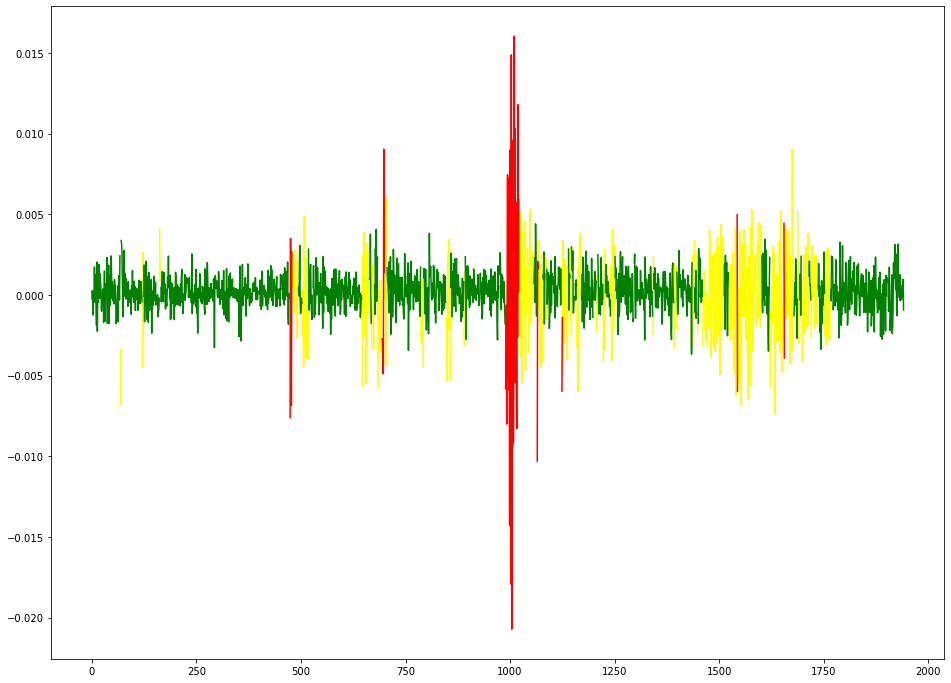

In [20]:
state1,state2,state3 = [],[],[]
i = 0
for state in states:
  if state == 0:
    state1.append(test_data['Returns'][i])
    state2.append(float('nan'))
    state3.append(float('nan'))
  if state == 1:
    state2.append(test_data['Returns'][i])
    state1.append(float('nan'))
    state3.append(float('nan'))
  if state == 2:
    state3.append(test_data['Returns'][i])
    state2.append(float('nan'))
    state1.append(float('nan'))
  i += 1
plt.plot(state1,color='yellow')
plt.plot(state2,color='green')
plt.plot(state3,color='red')

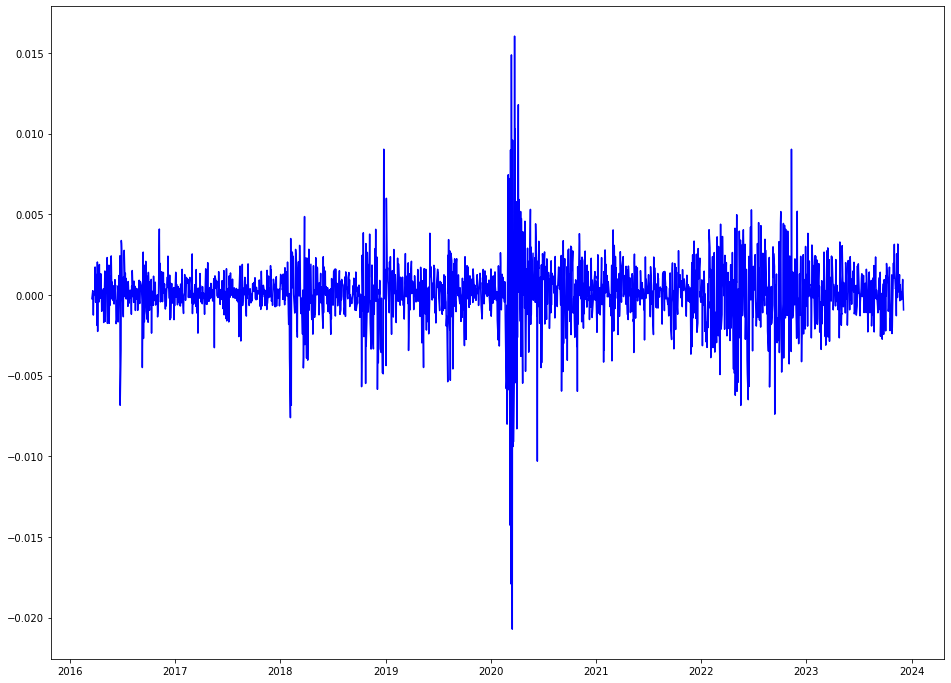

In [21]:
plt.plot(test_data['Returns'],color='blue')

In [22]:
print(np.size(test_data))

3884


In [23]:
print(np.size(states))

1942


In [24]:
print(test_data)

             Returns     Range
Date                          
2016-03-18 -0.000230  0.004809
2016-03-21  0.000267  0.005594
2016-03-22 -0.000101  0.008154
2016-03-23 -0.001244  0.006502
2016-03-24 -0.000083  0.007039
...              ...       ...
2023-11-28  0.000162  0.006108
2023-11-29 -0.000115  0.009071
2023-11-30  0.000642  0.007544
2023-12-01  0.000963  0.009865
2023-12-04 -0.000927  0.005480

[1942 rows x 2 columns]


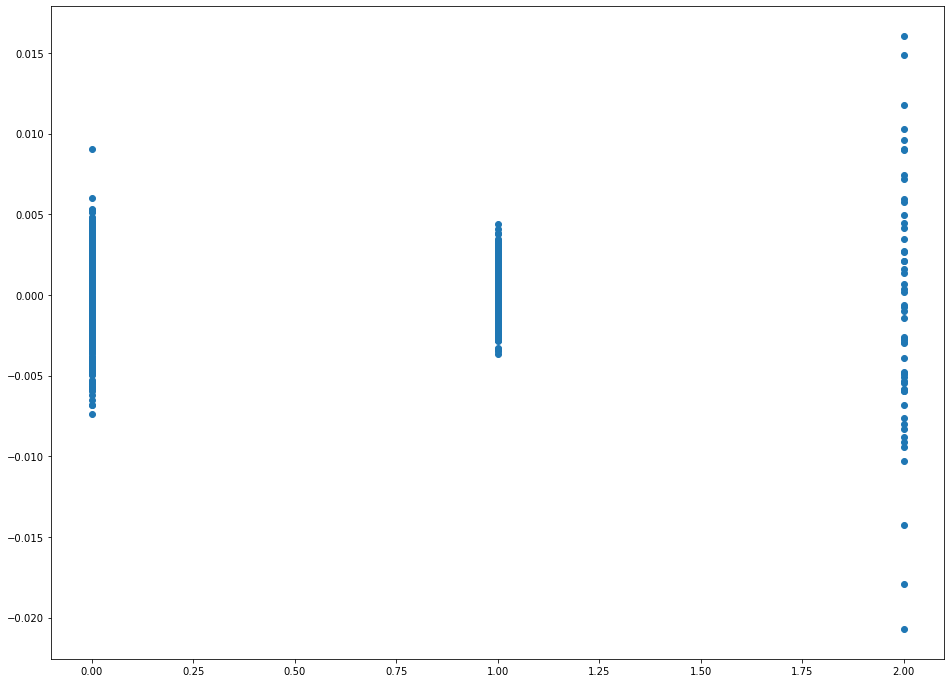

In [27]:
plt.scatter(states,test_data['Returns'])